In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

import matplotlib.pyplot as plt

import logging
logging.basicConfig(filename='training.log', level = logging.INFO, format='%(asctime)s %(message)s')

In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

train_images /= 255.
test_images /= 255.
 
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

BATCH_SIZE = 128

train = tf.data.Dataset.from_tensor_slices(train_images).shuffle(
    train_images.shape[0]).batch(BATCH_SIZE)
test = tf.data.Dataset.from_tensor_slices(test_images).batch(BATCH_SIZE)

In [3]:
train_iterator = iter(train)
next(train_iterator).shape

TensorShape([128, 28, 28, 1])

In [4]:
latent_dim=50

inference_net = tf.keras.Sequential([
                  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                  tf.keras.layers.Conv2D(
                      filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                  tf.keras.layers.Conv2D(
                      filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                  tf.keras.layers.Flatten(),
                  # No activation
                  tf.keras.layers.Dense(latent_dim + latent_dim),
              ])

generative_net = tf.keras.Sequential([
                  tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                  tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                  tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                  tf.keras.layers.Conv2DTranspose(
                      filters=64,
                      kernel_size=3,
                      strides=(2, 2),
                      padding="SAME",
                      activation='relu'),
                  tf.keras.layers.Conv2DTranspose(
                      filters=32,
                      kernel_size=3,
                      strides=(2, 2),
                      padding="SAME",
                      activation='relu'),
                  # No activation
                  tf.keras.layers.Conv2DTranspose(
                      filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
                ])

In [5]:
from autoencoders.vae_models import GaussianVAE, CauchyVAE, VAE
from autoencoders import loss_functions as loss

In [6]:
import time

epochs = 3

model = CauchyVAE(latent_dim=2, eps_scale=0.01, decoder_dist=tfd.Normal)
#     #latent_dim=50, 
#     inference_net=inference_net, 
#     generative_net=generative_net)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
compute_loss = loss.loss_elbo_cross_ent

In [7]:
model.latent_dist_, model.decoder_dist_, model.prior_dist_, model.decoder_eps_scale

(tensorflow_probability.python.distributions.cauchy.Cauchy,
 tensorflow_probability.python.distributions.normal.Normal,
 tensorflow_probability.python.distributions.cauchy.Cauchy,
 0.01)

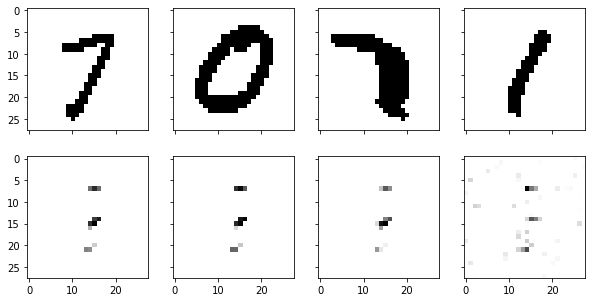

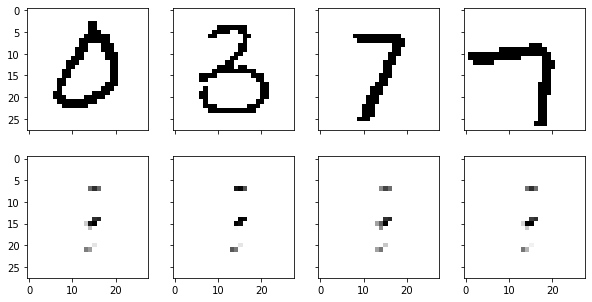

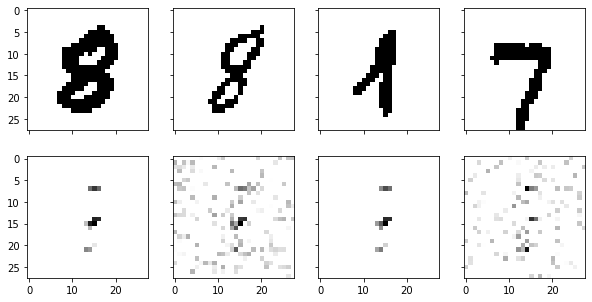

In [9]:
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train:
        loss.compute_apply_gradients(model, train_x, compute_loss, optimizer, cross_ent='sigmoid')
    end_time = time.time()

    if epoch % 1 == 0:
        mean_loss = tf.keras.metrics.Mean()
        kl = tf.keras.metrics.Mean()
        likelihood = tf.keras.metrics.Mean()
        for test_x in test:
            loss_dict = compute_loss(model, test_x)
            mean_loss(loss_dict['final'])
            kl(loss_dict['kl'])
            likelihood(loss_dict['likelihood'])     
       # display.clear_output(wait=False)
        logging.info('Epoch: {}, Test set ELBO: {}, KL: {}, likelihood: {},'
          ' time elapsed for current epoch: {}'.format(epoch,
                                                    -mean_loss.result(),
                                                    kl.result(),
                                                    likelihood.result(),
                                                    end_time - start_time))
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5), sharex=True, sharey=True)
        for i, ax_col in enumerate(axes.T):
            ax_col[0].imshow(train_x[i, ..., 0], cmap='binary')
            ax_col[1].imshow(model(train_x, apply_sigmoid=True)['decoded'][i, ..., 0], cmap='binary')
        plt.show()